   <h1><b>MOVIE RECOMMENDER SYSTEMS</b></h1>

<img src="netflix.png">

<h2><b>Importing libraries</b></h2>

We have imported the dependencies

In [ ]:
pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3162737 sha256=468cd4379600b295614ca0d773e167c79a233ca7ca86c14c6c37de3130894a91
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [ ]:
import pandas as pd
import numpy as np
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
import warnings; warnings.simplefilter('ignore')
from nltk.stem.snowball import SnowballStemmer
from surprise import Reader, Dataset, SVD,BaselineOnly,NormalPredictor,accuracy
from surprise.model_selection import cross_validate,train_test_split
import matplotlib.pyplot as plt

<h2><b>Loading Dataset</b></h2>

We have used Movie lens dataset for the building recommender systems

Full dataset: This dataset consists of 26,000,000 ratings by 270,000 users for 45,000 movies.

Sample dataset: we have taken The subset of 100,000 ratings from 700 users on 9,000 movies for building recommender system.

In [ ]:
del credits
del keywords
del links_small
del meta_data
del small_ratings
del full_ratings

NameError: name 'keywords' is not defined

In [ ]:
credits = pd.read_csv('/content/credits.csv')
keywords = pd.read_csv('/content/keywords.csv')
links_small = pd.read_csv('/content/links_small.csv')
meta_data = pd.read_csv('/content/movies_metadata.csv')
small_ratings = pd.read_csv('/content/ratings_small.csv')
full_ratings = pd.read_csv('/content/ratings.csv')

<h2><b>Understanding the Dataset</b></h2>

In [ ]:
full_ratings.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,1.425942e+09
1,1,147,4.5,1.425942e+09
2,1,858,5.0,1.425942e+09
3,1,1221,5.0,1.425942e+09
4,1,1246,5.0,1.425942e+09


<b>userId:</b> It is id for User

<b>movieId:</b> It is TMDb movie id.

<b>rating:</b> Rating given for the particular movie by specific user

<b>timestamp:</b> Time stamp when rating has been given by user

In [ ]:
full_ratings['rating'].value_counts()

4.0    1990026
3.0    1505052
5.0    1071918
3.5     895568
4.5     612986
2.0     496288
2.5     360419
1.0     233459
1.5     112668
0.5     110296
Name: rating, dtype: int64

In [ ]:
print('users count: {}\nmovies count: {}'.format(full_ratings['userId'].nunique(), full_ratings['movieId'].nunique()))
movie_mean_rating = pd.DataFrame(full_ratings.groupby('movieId')['rating'].mean())
movie_mean_rating['num_ratings'] = full_ratings.groupby('movieId')['rating'].count()
movie_mean_rating.head()

users count: 255279
movies count: 44731


,rating,num_ratings
movieId,,
1.0,3.886805,62295
2.0,3.237567,24673
3.0,3.175699,14596
4.0,2.873981,2821
5.0,3.079564,14391


Text(0, 0.5, 'Frequency')

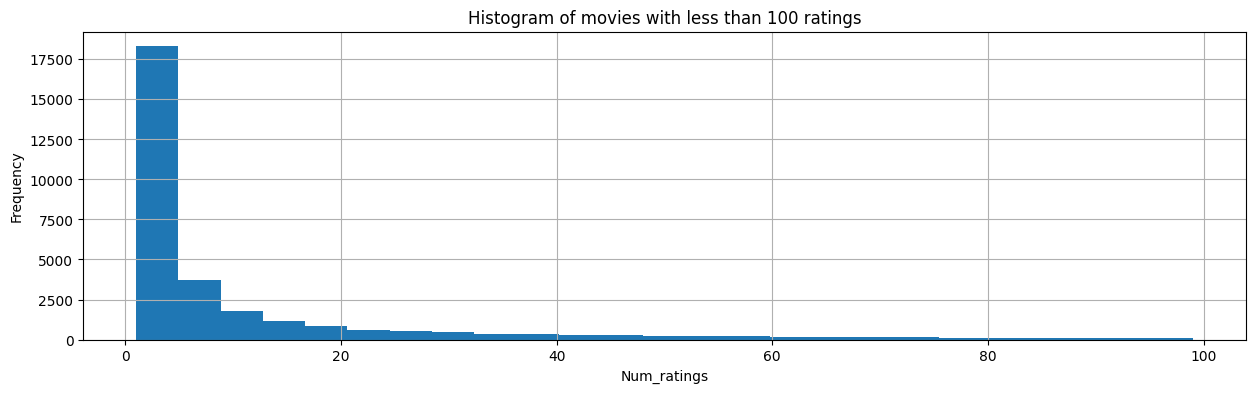

In [ ]:
plt.figure(figsize=(15,4))
movie_mean_rating[movie_mean_rating['num_ratings'] < 100]['num_ratings'].hist(bins=25)
plt.title('Histogram of movies with less than 100 ratings')
plt.xlabel("Num_ratings")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

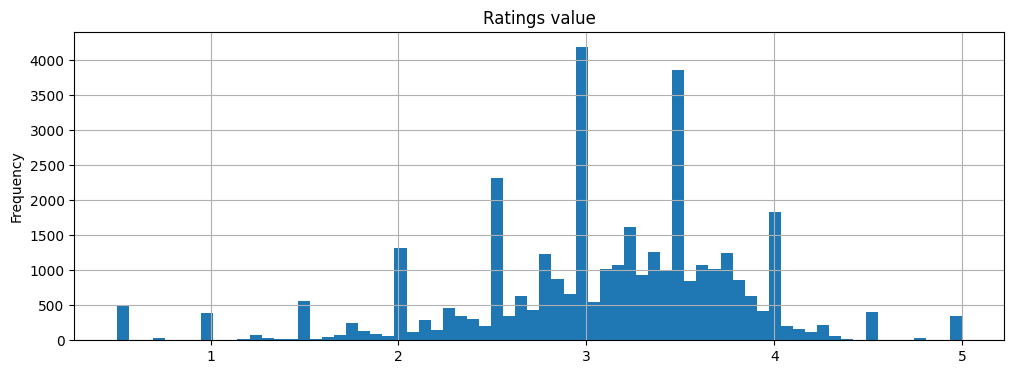

In [ ]:
plt.figure(figsize=(12,4))
movie_mean_rating['rating'].hist(bins=70)
plt.title('Ratings value')
plt.ylabel("Frequency")

In [ ]:
credits.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


<b>cast:</b> Information about casting. Name of actor, gender and it's character name in movie

<b>crew:</b> Information about crew members. About director, editor and writer etc.,

<b>id:</b> It's movie ID given by TMDb

In [ ]:
credits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45476 entries, 0 to 45475
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   cast    45476 non-null  object
 1   crew    45476 non-null  object
 2   id      45476 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.0+ MB


In [ ]:
keywords.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


<b>id:</b> It's movie ID given by TMDb

<b>Keywords:</b> Tags/keywords for the movie. It list of tags/keywords

In [ ]:
keywords.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46419 entries, 0 to 46418
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        46419 non-null  int64 
 1   keywords  46419 non-null  object
dtypes: int64(1), object(1)
memory usage: 725.4+ KB


In [ ]:
links_small.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


<b>movieId:</b> It's serial number for movie

<b>imdbId:</b> Movie id given on IMDb platform

<b>tmdbId:</b> Movie id given on TMDb platform

In [ ]:
links_small.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9125 entries, 0 to 9124
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9125 non-null   int64  
 1   imdbId   9125 non-null   int64  
 2   tmdbId   9112 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 214.0 KB


In [ ]:
meta_data.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


<b>This dataset contains columns</b> - adult, belongs_to_collection, budget, genres, homepage, id, imdb_id, original_language, original_title, overview, release_date, revenue, runtime, spoken_languages, status, tagline, title, video, vote_average, vote_count

In [ ]:
meta_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

In [ ]:
full_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7388680 entries, 0 to 7388679
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  float64
dtypes: float64(2), int64(2)
memory usage: 225.5 MB


In [ ]:
links_small = links_small[links_small['tmdbId'].notna()]['tmdbId'].astype('int')

In [ ]:
links_small

0          862
1         8844
2        15602
3        31357
4        11862
         ...  
9120    402672
9121    315011
9122    391698
9123    137608
9124    410803
Name: tmdbId, Length: 9112, dtype: int64

In [ ]:
meta_data.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [ ]:
def to_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [ ]:
meta_data['id'] = meta_data['id'].apply(to_int)

In [ ]:
meta_data=meta_data.drop(meta_data[meta_data['id'].isnull()].index)
print(f'Remaining NaN values count { meta_data.id.isna().sum()}')
meta_data['id'] = meta_data['id'].astype('int')

Remaining NaN values count 0


In [ ]:
filtered_meta_data = meta_data[meta_data['id'].isin(links_small)]
filtered_meta_data.shape

(9099, 24)

<h2><b>Pre-processing</b></h2>
    
We have taken the sample dataset form the original full dataset and performed the pre processing activity as and when required for each model implementation.

<h2><b>Building recommender systems</b></h2>

The Simple Recommender system offers generalized recommendations to every user based on movie popularity and genre.

We have implemented the recommender systems based on the following types:

1. Content based recommendation model
2. Colloborative recommendation model
3. Hybrid recommendation model


<h2><b>Content based recommendation model by Using movie description & taglines</b></h2>

The Basic idea behind the <b>Content based model</b> filtering relies upon similarities between the items themselves. That is between the two movies or two songs or two purchased items.

Here, the content based model first we need to figure out the similarities between the movies. These similarities can be features or qualities of each movies.

<h4> Steps perfomed to carry out the Content based filtering </h4>

1. First, We have combined the "tagline" and "overview" from the meta_data.csv and created a new filed called "description"

2. we have foumd the <b>TF-IDF vectorizer</b> for the "description" and picked the most important words from the column.

3. Finally we have found the <b>cosine similarity</b> for the tf-idf matrix.

4. Based on the similarity strength we have filtered and sorted the best movies to recommend to the user.

In [ ]:
filtered_meta_data['tagline'] = filtered_meta_data['tagline'].fillna('')
filtered_meta_data['description'] = filtered_meta_data['overview'] + filtered_meta_data['tagline']
filtered_meta_data['description'] = filtered_meta_data['description'].fillna('')

In [ ]:
filtered_meta_data['description'][1]

"When siblings Judy and Peter discover an enchanted board game that opens the door to a magical world, they unwittingly invite Alan -- an adult who's been trapped inside the game for 26 years -- into their living room. Alan's only hope for freedom is to finish the game, which proves risky as all three find themselves running from giant rhinoceroses, evil monkeys and other terrifying creatures.Roll the dice and unleash the excitement!"

In [ ]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(filtered_meta_data['description'])

In [ ]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [ ]:
cosine_sim[0]

array([1.        , 0.00680476, 0.        , ..., 0.        , 0.00344913,
       0.        ])

In [ ]:
filtered_meta_data = filtered_meta_data.reset_index()
titles = filtered_meta_data['title']
indices = pd.Series(filtered_meta_data.index, index=filtered_meta_data['title'])
#indices.head(2)

In [ ]:
def get_recommendations(title):
    if type(indices[title])==np.int64:
        idx = indices[title]
    else:
        idx=indices[title][:1][0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [ ]:
get_recommendations('Harry Potter and the Chamber of Secrets').head(10)

5390        Harry Potter and the Prisoner of Azkaban
6280             Harry Potter and the Goblet of Fire
7649    Harry Potter and the Deathly Hallows: Part 1
7821    Harry Potter and the Deathly Hallows: Part 2
7257          Harry Potter and the Half-Blood Prince
6720       Harry Potter and the Order of the Phoenix
3806        Harry Potter and the Philosopher's Stone
3840             Porn Star: The Legend of Ron Jeremy
3542                                   The Dead Pool
2903                            The Fighting Seabees
Name: title, dtype: object

In [ ]:
get_recommendations('The Dark Knight').head(10)

7931                      The Dark Knight Rises
132                              Batman Forever
1113                             Batman Returns
8227    Batman: The Dark Knight Returns, Part 2
7565                 Batman: Under the Red Hood
524                                      Batman
7901                           Batman: Year One
2579               Batman: Mask of the Phantasm
2696                                        JFK
8165    Batman: The Dark Knight Returns, Part 1
Name: title, dtype: object

<h2><b>Content based by Using movie description,taglines,keywords, cast, director and genres</b></h2>

Here, as a continuation for the content based model we have added more features for improving the recommendation model.

1. movie description,taglines,keywords, cast, director and genres are the additional features which are added to the list in implementing the model.
2. Performed the same steps as above and based on the similarity strength we have filtered and sorted the best movies to recommend to the user.
3. We could see some improvements in the results of the model after adding more features into the list.

In [ ]:
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
meta_data['id'] = meta_data['id'].apply(to_int)

In [ ]:
meta_data = meta_data.merge(credits, on='id')
meta_data = meta_data.merge(keywords, on='id')

In [ ]:
filtered_meta_data = meta_data[meta_data['id'].isin(links_small)]
filtered_meta_data.shape

(9219, 27)

In [ ]:
filtered_meta_data['cast'] = filtered_meta_data['cast'].apply(literal_eval)
filtered_meta_data['crew'] = filtered_meta_data['crew'].apply(literal_eval)
filtered_meta_data['keywords'] = filtered_meta_data['keywords'].apply(literal_eval)

In [ ]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [ ]:
filtered_meta_data['director'] = filtered_meta_data['crew'].apply(get_director)
filtered_meta_data['director'] = filtered_meta_data['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
filtered_meta_data['director'] = filtered_meta_data['director'].apply(lambda x: [x,x, x])
filtered_meta_data['cast'] = filtered_meta_data['cast'].apply(lambda x: [i['name'] for i in x])
filtered_meta_data['cast'] = filtered_meta_data['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)
filtered_meta_data['cast'] = filtered_meta_data['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])
filtered_meta_data['keywords'] = filtered_meta_data['keywords'].apply(lambda x: [i['name'] for i in x])
filtered_meta_data['genres'] = filtered_meta_data['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x])

In [ ]:
stemming = filtered_meta_data.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
stemming.name = 'keyword'
stemming = stemming.value_counts()
stemming = stemming[stemming > 1]
stemming[:10]

independent film        610
woman director          550
murder                  399
duringcreditsstinger    327
based on novel          318
violence                264
love                    222
musical                 219
sex                     219
suspense                212
Name: keyword, dtype: int64

In [ ]:
def useful_keywords(x):
    words = []
    for i in x:
        if i in stemming:
            words.append(i)
    return words

In [ ]:
filtered_meta_data['keywords'] = filtered_meta_data['keywords'].apply(useful_keywords)
filtered_meta_data['keywords'] = filtered_meta_data['keywords'].apply(lambda x: [SnowballStemmer('english').stem(i) for i in x])
filtered_meta_data['keywords'] = filtered_meta_data['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])
filtered_meta_data['soup'] = filtered_meta_data['keywords'] + filtered_meta_data['cast']+ filtered_meta_data['director'] + filtered_meta_data['genres']
filtered_meta_data['soup'] = filtered_meta_data['soup'].apply(lambda x: ' '.join(x))

In [ ]:
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(filtered_meta_data['soup'])

In [ ]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [ ]:
filtered_meta_data = filtered_meta_data.reset_index()
titles = filtered_meta_data['title']
indices = pd.Series(filtered_meta_data.index, index=filtered_meta_data['title'])

In [ ]:
get_recommendations('The Dark Knight').head(10)

8031         The Dark Knight Rises
6218                 Batman Begins
6623                  The Prestige
2085                     Following
7648                     Inception
4145                      Insomnia
3381                       Memento
8613                  Interstellar
7659    Batman: Under the Red Hood
1134                Batman Returns
Name: title, dtype: object

<h2><b>Collaborative recommender system</b></h2>

The basic idea behind the <b>collabarative filtering model</b> is, Suppose we have a user X to whom we want to make the recommendations. Here, we are going to find the other users/items whose likes and dislikes matches with X.

We call these group of users the neighbourhood of X. We find the other movies that are liked by the group of users and recommend those movies to the user X.

1. User-based collaborative filtering
2. Item based collaborative filtering

We will discuss about the Item based collaborative filtering.

<h2><b>Item-Based Collaborate filtering.</b></h2>

Steps performed to implement the item based collaborative filtering:

1. Find every pair of movies that were watched by the same person.
2. Measure the similarity of their ratings across all users who watched both.
3. Sort by movie, then by similarity strength and reommend it to the user.

In [ ]:
ratings_cols = ['user_id', 'movie_id', 'rating']
#ratings = pd.read_csv('./data/ratings.dat', sep = '::', names = ratings_cols, usecols = range(3), encoding = 'latin-1')
ratings = pd.read_csv('https://raw.githubusercontent.com/sidooms/MovieTweetings/master/latest/ratings.dat', sep = '::', names = ratings_cols, usecols = range(3), encoding = 'latin-1',nrows=10000)


movie_cols = ['movie_id', 'title']
#movies = pd.read_csv('./data/movies.dat', sep = '::', names = movie_cols, usecols = range(2), encoding = 'latin-1')
movies = pd.read_csv('https://raw.githubusercontent.com/sidooms/MovieTweetings/master/latest/movies.dat', sep = '::', names = movie_cols, usecols = range(2), encoding = 'latin-1',nrows=10000)


# Combine the movie and ratings DataFrames into a single DataFrame
ratings = pd.merge(movies, ratings)

In [ ]:
user_rating_pivot = ratings.pivot_table(index=['user_id'],columns=['title'],values='rating')
user_rating_pivot.head()

title,...and justice for all. (1979),12 Angry Men (1957),2001: A Space Odyssey (1968),8Â½ (1963),A Bug's Life (1998),A Clockwork Orange (1971),A Few Good Men (1992),A Goofy Movie (1995),A Little Princess (1995),A Nightmare on Elm Street (1984),...,Willow (1988),Willy Wonka &amp; the Chocolate Factory (1971),Withnail &amp; I (1987),Witness (1985),Wolfen (1981),Young Guns II (1990),YÃ´jÃ» toshi (1987),Zelig (1983),Zerkalo (1975),Ã bout de souffle (1960)
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
correlation_matrix = user_rating_pivot.corr(method='pearson', min_periods=50)
correlation_matrix.head()

title,...and justice for all. (1979),12 Angry Men (1957),2001: A Space Odyssey (1968),8Â½ (1963),A Bug's Life (1998),A Clockwork Orange (1971),A Few Good Men (1992),A Goofy Movie (1995),A Little Princess (1995),A Nightmare on Elm Street (1984),...,Willow (1988),Willy Wonka &amp; the Chocolate Factory (1971),Withnail &amp; I (1987),Witness (1985),Wolfen (1981),Young Guns II (1990),YÃ´jÃ» toshi (1987),Zelig (1983),Zerkalo (1975),Ã bout de souffle (1960)
title,,,,,,,,,,,,,,,,,,,,,
...and justice for all. (1979),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12 Angry Men (1957),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001: A Space Odyssey (1968),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8Â½ (1963),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A Bug's Life (1998),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
user_given_ratings = user_rating_pivot.loc[1].dropna()
user_given_ratings

title
Species (1995)    8.0
Name: 1, dtype: float64

In [ ]:
similar_items = pd.Series()
for i in range(0, len(user_given_ratings.index)):
    # Finding similar movies to the already rated movies.
    sims = correlation_matrix[user_given_ratings.index[i]].dropna()
    # Based on how the user rated the movie scale the similarity values.
    sims = sims.map(lambda x: x * user_given_ratings[i])
    similar_items = similar_items.append(sims)

In [ ]:
similar_items.sort_values(inplace = True, ascending = False)
similar_items.head(10)

Series([], dtype: object)

In [ ]:
watched_list=[]
for i in similar_items.index:
    if i in user_given_ratings.index:
        watched_list.append(i)

In [ ]:
filtered_similar_items =similar_items.drop(watched_list)
filtered_similar_items.head(10)

Series([], dtype: object)

<h2><b>Collaborate filtering using Suprise Library.</b></h2>

By using the <b>Surprise Library</b> we built the train and test data to measure the performance of the recommender systems.

We fed the train data and predicted the RMSE error on the test dataset. The implementation steps are shown:

In [ ]:
full_ratings = full_ratings[['userId', 'movieId', 'rating', 'timestamp']]
full_ratings = full_ratings.iloc[:, :-1]

In [ ]:
reader = Reader()
full_ratings = Dataset.load_from_df(full_ratings[['userId', 'movieId', 'rating']], reader)

In [ ]:
trainset, testset = train_test_split(full_ratings, test_size=0.25)

In [ ]:
algo = SVD()
algo.fit(trainset)

In [ ]:
predictions = algo.test(testset)
accuracy.rmse(predictions)

RMSE: 0.8089


0.8089107813517046

In [ ]:
uid = str(196)  # raw user id (as in the ratings file)
iid = str(302)  # raw item id (as in the ratings file)
# get a prediction for specific users and items.
pred = algo.predict(uid, iid, r_ui=4, verbose=True)

user: 196        item: 302        r_ui = 4.00   est = 3.53   {'was_impossible': False}


<h2><b>Hybrid Recommendation System.</b></h2>

A system that combines content-based filtering and collaborative filtering could take advantage from both the representation of the content as well as the similarities among users also overcomes the problems within both the models.

The implementation steps are shown below:

By using both content based features and Collaborative model features we have implemented the hybrid model and the best results are displayed.

In [ ]:
link_id = pd.read_csv('/content/links_small.csv')[['movieId', 'tmdbId']]
link_id['tmdbId'] = link_id['tmdbId'].apply(to_int)
link_id.columns = ['movieId', 'id']
link_id = link_id.merge(filtered_meta_data[['title', 'id']], on='id').set_index('title')
id_index_link = link_id.set_index('id')

In [ ]:
def hybrid(userId, title):
    idx = indices[title]
    tmdbId = link_id.loc[title]['id']
    movie_id = link_id.loc[title]['movieId']
    sim_scores = list(enumerate(cosine_sim[int(idx)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    movies = filtered_meta_data.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'id']]
    movies['est'] = movies['id'].apply(lambda x: algo.predict(userId, id_index_link.loc[x]['movieId']).est)
    movies = movies.sort_values('est', ascending=False)
    return movies.head(10)

In [ ]:
hybrid(1, 'Harry Potter and the Chamber of Secrets')

,title,vote_count,vote_average,id,est
6354,Harry Potter and the Goblet of Fire,5758.0,7.5,674,4.336342
7345,Harry Potter and the Half-Blood Prince,5435.0,7.4,767,4.247707
5452,Harry Potter and the Prisoner of Azkaban,6037.0,7.7,673,4.217111
7921,Harry Potter and the Deathly Hallows: Part 2,6141.0,7.9,12445,4.201732
7742,Harry Potter and the Deathly Hallows: Part 1,5708.0,7.5,12444,4.176459
6801,Harry Potter and the Order of the Phoenix,5633.0,7.4,675,4.154636
3840,Harry Potter and the Philosopher's Stone,7188.0,7.5,671,4.007595
4509,The Last Unicorn,117.0,7.0,10150,3.929861
853,Bedknobs and Broomsticks,260.0,6.8,12335,3.856269
1664,Peter Pan,1380.0,7.0,10693,3.822064


In [ ]:
hybrid(89, "Avengers: Age of Ultron")

,title,vote_count,vote_average,id,est
7247,Dr. Horrible's Sing-Along Blog,236.0,7.8,14301,4.769194
4635,X2,3572.0,6.8,36658,4.480021
7009,Iron Man,8951.0,7.4,1726,4.475555
8712,Guardians of the Galaxy,10014.0,7.9,118340,4.442874
6252,Serenity,1287.0,7.4,16320,4.404727
8869,Ant-Man,6029.0,7.0,102899,4.384268
7923,Captain America: The First Avenger,7174.0,6.6,1771,4.365649
3049,X-Men,4172.0,6.8,36657,4.323196
7969,The Avengers,12000.0,7.4,24428,4.322886
7861,Thor,6678.0,6.6,10195,4.321153


In [ ]:
hybrid(999, "The Lord of the Rings: The Fellowship of the Ring")

,title,vote_count,vote_average,id,est
5074,The Lord of the Rings: The Return of the King,8226.0,8.1,122,3.990810
4436,The Lord of the Rings: The Two Towers,7641.0,8.0,121,3.943193
1693,The Lord of the Rings,187.0,6.1,123,3.572138
1026,Bad Taste,196.0,6.4,9964,3.571388
219,Heavenly Creatures,299.0,6.9,1024,3.474807
6368,King Kong,2403.0,6.6,254,3.273811
659,The Frighteners,413.0,6.7,10779,3.272288
8295,The Hobbit: An Unexpected Journey,8427.0,7.0,49051,3.245710
5852,The Hobbit,76.0,6.0,1362,3.216872
7543,Tom Thumb,8.0,6.2,56931,3.174332


In [ ]:
hybrid(99, "The Lord of the Rings: The Fellowship of the Ring")

,title,vote_count,vote_average,id,est
4436,The Lord of the Rings: The Two Towers,7641.0,8.0,121,4.613466
5074,The Lord of the Rings: The Return of the King,8226.0,8.1,122,4.594709
1693,The Lord of the Rings,187.0,6.1,123,3.822936
8537,The Hobbit: The Desolation of Smaug,4633.0,7.6,57158,3.747235
1012,Braindead,388.0,7.4,763,3.689402
8295,The Hobbit: An Unexpected Journey,8427.0,7.0,49051,3.677494
219,Heavenly Creatures,299.0,6.9,1024,3.625032
1026,Bad Taste,196.0,6.4,9964,3.622162
8833,The Hobbit: The Battle of the Five Armies,4884.0,7.1,122917,3.611992
5852,The Hobbit,76.0,6.0,1362,3.592694
